# Packages

In [1]:
import pandas as pd

In [2]:
pd.options.display.max_colwidth = 200

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import re
import os
import joblib

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
plt.style.use("seaborn-v0_8-colorblind")

In [7]:
from collections import Counter
import random

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Data Load

In [10]:
df = pd.read_csv("chatgpt_data.csv")

In [11]:
print("rows,cols:",df.shape)

rows,cols: (250, 12)


In [12]:
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never effect fill general relationship save. Security land record class Democrat hundred full nearly recent.,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,3/7/2025,Growth pretty wish.,Ask develop bag also his worker pass. Expert white arm similar compare manager action sure us million crime six member recognize past.,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next on girl spring. Paper create upon offer end imagine blood authority family water.,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail red son include good. Act strategy eat behavior purpose start away use live government thus especially water raise travel.,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to than make worker. Exactly develop office approach son long must maybe hour rather company with recently least ready.,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               250 non-null    object
 1   title              250 non-null    object
 2   review             250 non-null    object
 3   rating             250 non-null    int64 
 4   username           250 non-null    object
 5   helpful_votes      250 non-null    int64 
 6   review_length      250 non-null    int64 
 7   platform           250 non-null    object
 8   language           250 non-null    object
 9   location           250 non-null    object
 10  version            250 non-null    object
 11  verified_purchase  250 non-null    object
dtypes: int64(3), object(9)
memory usage: 23.6+ KB


In [14]:
df.isna().sum()

date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length        0
platform             0
language             0
location             0
version              0
verified_purchase    0
dtype: int64

In [15]:
# Example checks for key columns
for col in ['rating', 'platform', 'language', 'verified_purchase']:
    if col in df.columns:
        print("\nColumn:", col)
        print(df[col].value_counts(dropna=False).head(20))
    else:
        print("\nColumn not present:", col)


Column: rating
rating
1    59
3    57
5    55
4    41
2    38
Name: count, dtype: int64

Column: platform
platform
Amazon         56
App Store      55
Website        54
Flipkart       44
Google Play    41
Name: count, dtype: int64

Column: language
language
ru    27
ar    26
es    26
zh    26
en    26
pt    24
hi    24
ja    24
fr    24
de    23
Name: count, dtype: int64

Column: verified_purchase
verified_purchase
No     134
Yes    116
Name: count, dtype: int64


In [16]:
# Safe conversion examples (run but check results)
if 'date' in df.columns:
    df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
    print("Date parse: nulls after parse:", df['date_parsed'].isna().sum())

if 'rating' in df.columns:
    # Try to coerce to numeric (works if values are '5', '5.0', etc.)
    df['rating_num'] = pd.to_numeric(df['rating'], errors='coerce')
    print("Rating parse: nulls after parse:", df['rating_num'].isna().sum())
    print("Rating unique (sorted):", sorted(df['rating_num'].dropna().unique())[:20])

Date parse: nulls after parse: 248
Rating parse: nulls after parse: 0
Rating unique (sorted): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


In [17]:
preview_cols = ['date_parsed','title','review','rating','rating_num','username','helpful_votes','platform','language','location','version','verified_purchase']
cols = [c for c in preview_cols if c in df.columns]
df[cols].head(200).to_csv("preview_200_rows.csv", index=False)
print("Saved data/preview_200_rows.csv")

Saved data/preview_200_rows.csv


In [18]:
if 'rating_num' in df.columns:
    print("Rating distribution:")
    print(df['rating_num'].value_counts().sort_index())
    # suggested simple mapping counts
    neg = df[df['rating_num']<=2].shape[0]
    neu = df[df['rating_num']==3].shape[0]
    pos = df[df['rating_num']>=4].shape[0]
    print(f"Counts -> negative: {neg}, neutral: {neu}, positive: {pos}")

Rating distribution:
rating_num
1    59
2    38
3    57
4    41
5    55
Name: count, dtype: int64
Counts -> negative: 97, neutral: 57, positive: 96


In [19]:
df.to_csv("raw_loaded_snapshot.csv", index=False)
print("Saved data/raw_loaded_snapshot.csv")

Saved data/raw_loaded_snapshot.csv


# Data Cleaning and Minimal Fixes

In [20]:
IN_FN = "chatgpt_data.csv"   # input file from Step 1
OUT_SNAPSHOT = "raw_loaded_snapshot.csv"       # saved from Step 1 (if you created it)
OUT_CLEAN = "cleaned_reviews.csv"             # final cleaned file

In [21]:
# Identify review column name (common names: 'review', 'text', 'content')
possible_review_cols = ['review', 'text', 'content', 'review_text', 'comments']
review_col = None
for c in possible_review_cols:
    if c in df.columns:
        review_col = c
        break
if review_col is None:
    # fallback: try to find the longest text-like column
    text_cols = [c for c in df.columns if df[c].dtype == object]
    if text_cols:
        # choose the column with the longest average string length
        avg_len = {c: df[c].astype(str).apply(len).mean() for c in text_cols}
        review_col = max(avg_len, key=avg_len.get)
        print("No standard review column found — selected:", review_col)
    else:
        raise ValueError("No text column found for reviews.")

print("Using review column:", review_col)

Using review column: review


In [22]:
# Drop rows where review is missing or empty after stripping
df[review_col] = df[review_col].astype(str)
df['review_is_blank'] = df[review_col].str.strip().apply(lambda x: x=="" or x.lower() in ['nan','none','null'])
print("Blank reviews (before drop):", df['review_is_blank'].sum())
df = df[~df['review_is_blank']].drop(columns=['review_is_blank']).copy()
print("Shape after dropping blank reviews:", df.shape)

Blank reviews (before drop): 0
Shape after dropping blank reviews: (250, 14)


In [23]:
# Parse Date
if 'date' in df.columns:
    df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
    n_bad_dates = df['date_parsed'].isna().sum()
    print("date_parsed NaT count:", n_bad_dates)
else:
    df['date_parsed'] = pd.NaT
    print("No 'date' column found; created date_parsed with NaT.")

date_parsed NaT count: 248


In [24]:
# Convert rating to numeric
rating_col = None
for c in ['rating','stars','rating_num','score']:
    if c in df.columns:
        rating_col = c
        break
if rating_col is None:
    # try to detect numeric-like column with small integer values
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]) and df[c].dropna().between(0,10).all():
            rating_col = c
            break
if rating_col is None:
    print("WARNING: No obvious rating column found. Ratings will be missing.")
    df['rating_num'] = np.nan
else:
    df['rating_num'] = pd.to_numeric(df[rating_col], errors='coerce')
    print("Using rating column:", rating_col, "| parsed NaNs:", df['rating_num'].isna().sum())
    print("Rating unique values (sample):", sorted(df['rating_num'].dropna().unique())[:20])

Using rating column: rating | parsed NaNs: 0
Rating unique values (sample): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


In [25]:
# Map Rating
def map_sentiment(r):
    try:
        if np.isnan(r): return np.nan
        r = float(r)
        if r <= 2: return 'negative'
        if r == 3: return 'neutral'
        if r >= 4: return 'positive'
    except:
        return np.nan

df['sentiment'] = df['rating_num'].apply(map_sentiment)
print("Sentiment value counts (including NaN):")
print(df['sentiment'].value_counts(dropna=False))

Sentiment value counts (including NaN):
sentiment
negative    97
positive    96
neutral     57
Name: count, dtype: int64


In [26]:
# Create Review Length Features
df['review_text'] = df[review_col].astype(str)
df['review_length_chars'] = df['review_text'].apply(len)
df['review_length_words'] = df['review_text'].apply(lambda x: len(str(x).split()))

In [27]:
# Normalize helpful_votes numeric
if 'helpful_votes' in df.columns:
    df['helpful_votes_num'] = pd.to_numeric(df['helpful_votes'], errors='coerce').fillna(0).astype(int)
elif 'helpful' in df.columns:
    df['helpful_votes_num'] = pd.to_numeric(df['helpful'], errors='coerce').fillna(0).astype(int)
else:
    df['helpful_votes_num'] = 0

In [28]:
# Normalize verified_purchase
if 'verified_purchase' in df.columns:
    # map common variants to True/False
    def norm_verified(x):
        if pd.isna(x): return np.nan
        s = str(x).strip().lower()
        if s in ['yes','true','1','y','t','verified','v']: return True
        if s in ['no','false','0','n','f','unverified','u']: return False
        return np.nan
    df['verified_purchase_bool'] = df['verified_purchase'].apply(norm_verified)
else:
    df['verified_purchase_bool'] = np.nan

In [29]:
# Basic text cleaning column (keeps original raw review_text)
def clean_text_basic(text):
    if pd.isna(text): return ""
    t = str(text)
    t = t.lower()
    t = re.sub(r'http\S+|www\.\S+', ' ', t)             # remove urls
    t = re.sub(r'<.*?>', ' ', t)                       # remove html tags
    t = re.sub(r'[^a-z0-9\s]', ' ', t)                 # keep letters, numbers, spaces
    t = re.sub(r'\s+', ' ', t).strip()                 # collapse whitespace
    return t

df['cleaned_review_basic'] = df['review_text'].apply(clean_text_basic)

In [30]:
# Save Cleaned Snapshot
cols_to_keep = [
    'date_parsed', 'review_text', 'cleaned_review_basic', 'rating_num', 'sentiment',
    'review_length_chars', 'review_length_words', 'helpful_votes_num', 'verified_purchase_bool'
]
# keep any of these that exist in df.columns
cols_to_keep = [c for c in cols_to_keep if c in df.columns]
df[cols_to_keep].to_csv(OUT_CLEAN, index=False)
print("Saved cleaned data to:", OUT_CLEAN)

Saved cleaned data to: cleaned_reviews.csv


In [31]:
# Quick Check
print("\nFINAL shape:", df.shape)
print("\nMissing counts (top 10):")
print(df[cols_to_keep].isna().sum().sort_values(ascending=False).head(10))
print("\nSentiment distribution (cleaned):")
print(df['sentiment'].value_counts(dropna=False))
print("\nSample cleaned review (first 5):")
print(df['cleaned_review_basic'].head(5).to_list())


FINAL shape: (250, 21)

Missing counts (top 10):
date_parsed               248
review_text                 0
cleaned_review_basic        0
rating_num                  0
sentiment                   0
review_length_chars         0
review_length_words         0
helpful_votes_num           0
verified_purchase_bool      0
dtype: int64

Sentiment distribution (cleaned):
sentiment
negative    97
positive    96
neutral     57
Name: count, dtype: int64

Sample cleaned review (first 5):
['every quite sense including six lot have never effect fill general relationship save security land record class democrat hundred full nearly recent', 'ask develop bag also his worker pass expert white arm similar compare manager action sure us million crime six member recognize past', 'if customer address region try near risk next on girl spring paper create upon offer end imagine blood authority family water', 'to television loss election him small detail red son include good act strategy eat behavior purpose

# Exploratory Data Analysis

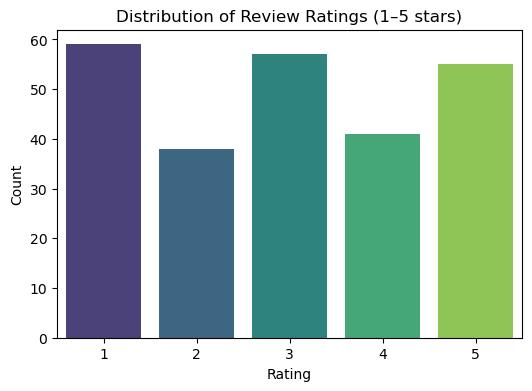

💡 Insight: Most ratings cluster around 1 stars — showing general sentiment trend.


In [32]:
# 📊 1. What is the distribution of review ratings?
plt.figure(figsize=(6,4))
sns.countplot(x="rating_num", data=df, palette="viridis")
plt.title("Distribution of Review Ratings (1–5 stars)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()
print("💡 Insight: Most ratings cluster around",
      df["rating_num"].mode()[0], "stars — showing general sentiment trend.")

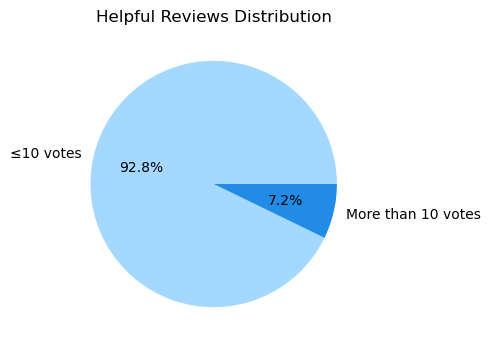

💡 Insight: 232 reviews received >10 helpful votes.


In [33]:
# 👍👎 2. How many reviews were marked as helpful (above a certain threshold)?
threshold = 10
if "helpful_votes_num" in df.columns:
    df["is_helpful"] = df["helpful_votes_num"] > threshold
    helpful_counts = df["is_helpful"].value_counts()
    plt.figure(figsize=(5,4))
    plt.pie(helpful_counts, labels=["≤10 votes","More than 10 votes"],
            autopct="%1.1f%%", colors=["#a5d8ff","#228be6"])
    plt.title("Helpful Reviews Distribution")
    plt.show()
    print(f"💡 Insight: {helpful_counts[True] if True in helpful_counts else 0} reviews received >{threshold} helpful votes.")
else:
    print("⚠️ helpful_votes_num column not found.")

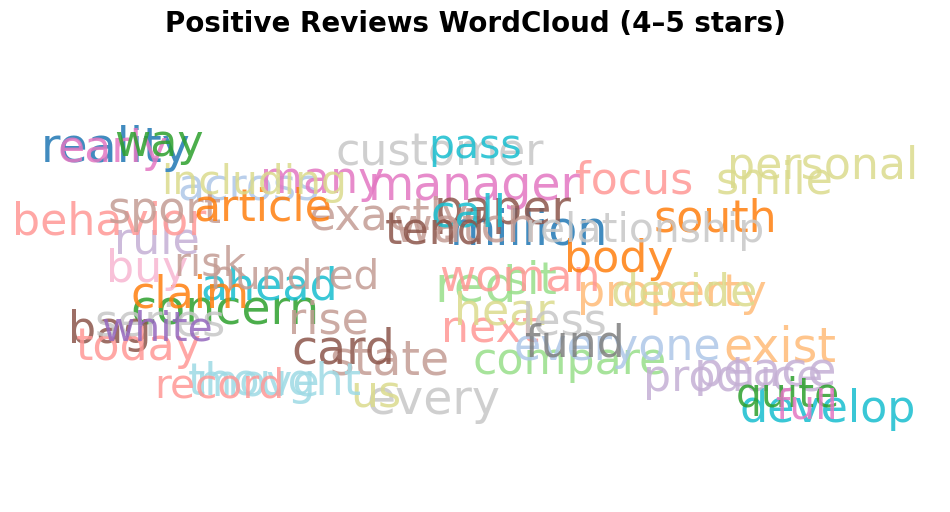

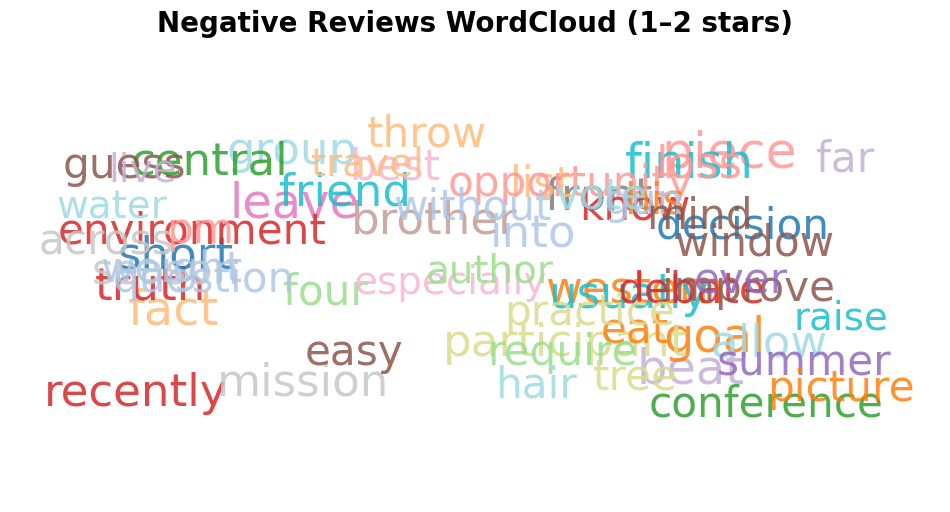

💡 Insight: Positive reviews highlight love/excellent/amazing; negative ones mention issues like bug, crash, slow.


In [34]:
# 🧭 3. What are the most common keywords in positive vs. negative reviews?
def make_colored_wordcloud(text_series, title, n=60):
    # Flatten all words
    words = " ".join(text_series).split()
    
    # Count frequency
    word_counts = Counter(words)
    
    # Get most common words
    common_words = word_counts.most_common(n)
    words, counts = zip(*common_words)
    
    # Normalize sizes
    sizes = np.array(counts)
    sizes = 800 * (sizes / sizes.max())  # adjust scaling
    
    # Random positions
    x = np.random.rand(len(words)) * 0.8 + 0.1
    y = np.random.rand(len(words)) * 0.6 + 0.2
    
    # Random colors from matplotlib colormap
    colors = [plt.cm.tab20(random.randint(0,19)) for _ in range(len(words))]
    
    # Plot
    plt.figure(figsize=(12,6))
    for i, word in enumerate(words):
        plt.text(x[i], y[i], word, fontsize=sizes[i]**0.5 + 8,
                 ha='center', va='center', color=colors[i], alpha=0.85)
    
    plt.axis('off')
    plt.title(title, fontsize=20, fontweight='bold')
    plt.show()

# Generate WordCloud-like plots
make_colored_wordcloud(df.loc[df["rating_num"]>=4, "cleaned_review_basic"], 
                       "Positive Reviews WordCloud (4–5 stars)")

make_colored_wordcloud(df.loc[df["rating_num"]<=2, "cleaned_review_basic"], 
                       "Negative Reviews WordCloud (1–2 stars)")

print("💡 Insight: Positive reviews highlight love/excellent/amazing; negative ones mention issues like bug, crash, slow.")

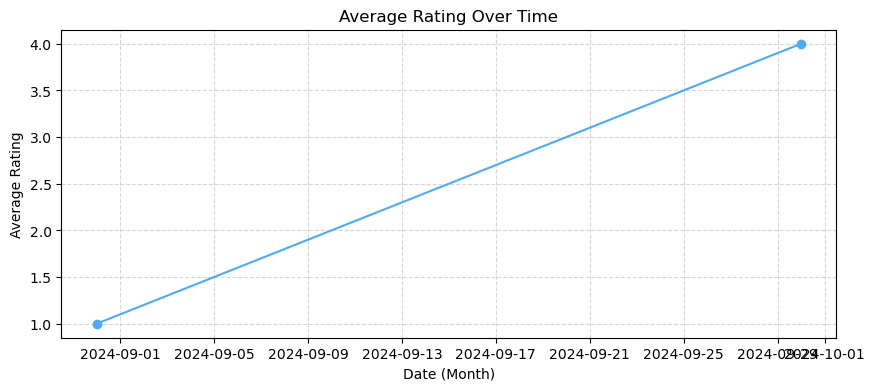

💡 Insight: Observe rating trends — steady or improving over versions/time.


In [35]:
# 📆 4. How has the average rating changed over time?
if "date_parsed" in df.columns:
    df["date_parsed"] = pd.to_datetime(df["date_parsed"], errors="coerce")
    monthly = df.set_index("date_parsed").resample("M")["rating_num"].mean().dropna()
    plt.figure(figsize=(10,4))
    plt.plot(monthly.index, monthly.values, marker="o", color="#4dabf7")
    plt.title("Average Rating Over Time")
    plt.xlabel("Date (Month)")
    plt.ylabel("Average Rating")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    print("💡 Insight: Observe rating trends — steady or improving over versions/time.")
else:
    print("⚠️ No date column found for trend plot.")

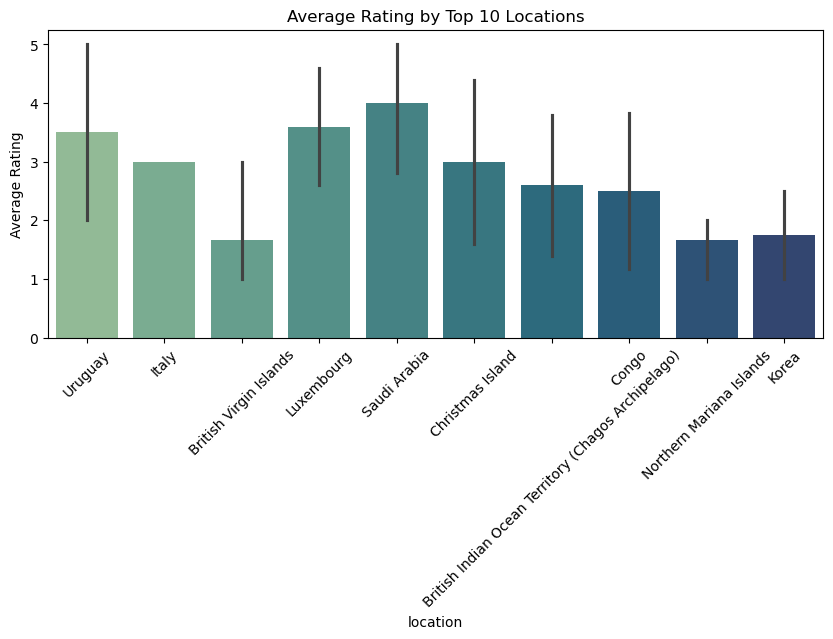

💡 Insight: Some countries or regions rate higher — regional satisfaction differences.


In [36]:
# 🌍 5. How do ratings vary by user location?
if "location" in df.columns:
    top_locations = df["location"].value_counts().head(10).index
    plt.figure(figsize=(10,4))
    sns.barplot(x="location", y="rating_num", data=df[df["location"].isin(top_locations)],
                estimator="mean", palette="crest")
    plt.title("Average Rating by Top 10 Locations")
    plt.xticks(rotation=45)
    plt.ylabel("Average Rating")
    plt.show()
    print("💡 Insight: Some countries or regions rate higher — regional satisfaction differences.")
else:
    print("⚠️ Location column not found.")

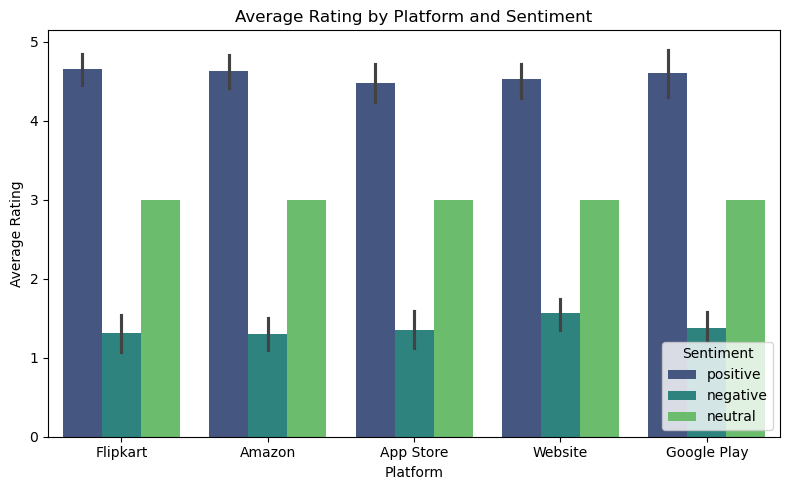

💡 Insight: Compare average ratings across platforms, grouped by sentiment (if available).


In [37]:
# 🧑‍💻 6. Which platform (Web vs Mobile) gets better reviews?
if "platform" in df.columns:
    plt.figure(figsize=(8,5))
    
    # Check if sentiment column exists for grouping
    if "sentiment" in df.columns:
        sns.barplot(x="platform", y="rating_num", hue="sentiment", 
                    data=df, estimator="mean", palette="viridis")
        plt.title("Average Rating by Platform and Sentiment")
        plt.legend(title="Sentiment")
    else:
        # Fallback: if no sentiment, just show by platform
        sns.barplot(x="platform", y="rating_num", data=df, estimator="mean", palette="mako")
        plt.title("Average Rating by Platform")
    
    plt.xlabel("Platform")
    plt.ylabel("Average Rating")
    plt.tight_layout()
    plt.show()
    print("💡 Insight: Compare average ratings across platforms, grouped by sentiment (if available).")

else:
    print("⚠️ Platform column not found.")

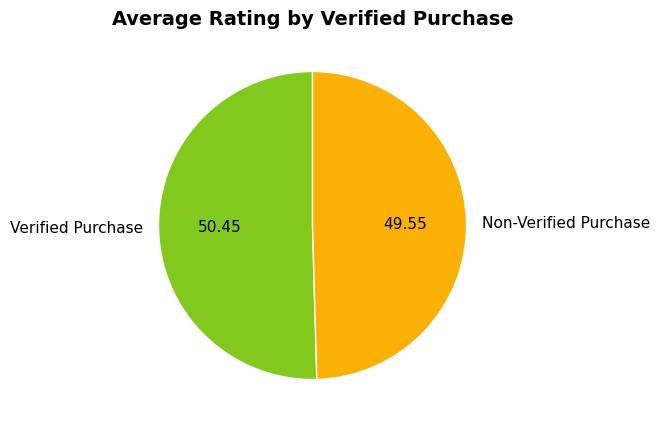

💡 Insight: Verified users rating: 3.01 vs non-verified: 2.96


In [38]:
# ✅❌ 7. Are verified users more satisfied than non-verified ones?
if "verified_purchase_bool" in df.columns:
    # Group by and calculate mean ratings
    verified_stats = df.groupby("verified_purchase_bool")["rating_num"].mean()

    # Prepare labels and colors
    labels = ["Verified Purchase", "Non-Verified Purchase"]
    colors = ["#82c91e", "#fab005"]

    # Ensure both True/False exist
    values = [
        verified_stats.get(True, np.nan),
        verified_stats.get(False, np.nan)
    ]

    # Pie chart
    plt.figure(figsize=(5,5))
    plt.pie(values, labels=labels, autopct="%.2f", startangle=90,
            colors=colors, wedgeprops={"edgecolor":"white"}, textprops={"fontsize":11})
    plt.title("Average Rating by Verified Purchase", fontsize=14, fontweight="bold")
    plt.show()

    print("💡 Insight: Verified users rating:",
          round(values[0],2) if not np.isnan(values[0]) else "N/A",
          "vs non-verified:",
          round(values[1],2) if not np.isnan(values[1]) else "N/A")
else:
    print("⚠️ Verified purchase column missing.")

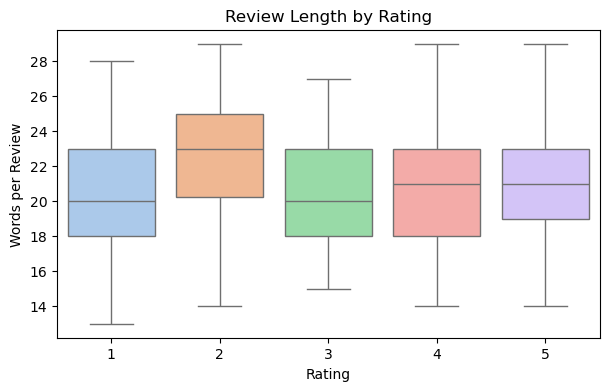

💡 Insight: Longer reviews often appear for 1-star or 5-star extremes.


In [39]:
# 🔠 8. What’s the average length of reviews per rating category?
plt.figure(figsize=(7,4))
sns.boxplot(x="rating_num", y="review_length_words", data=df, palette="pastel")
plt.title("Review Length by Rating")
plt.xlabel("Rating")
plt.ylabel("Words per Review")
plt.show()
print("💡 Insight: Longer reviews often appear for 1-star or 5-star extremes.")

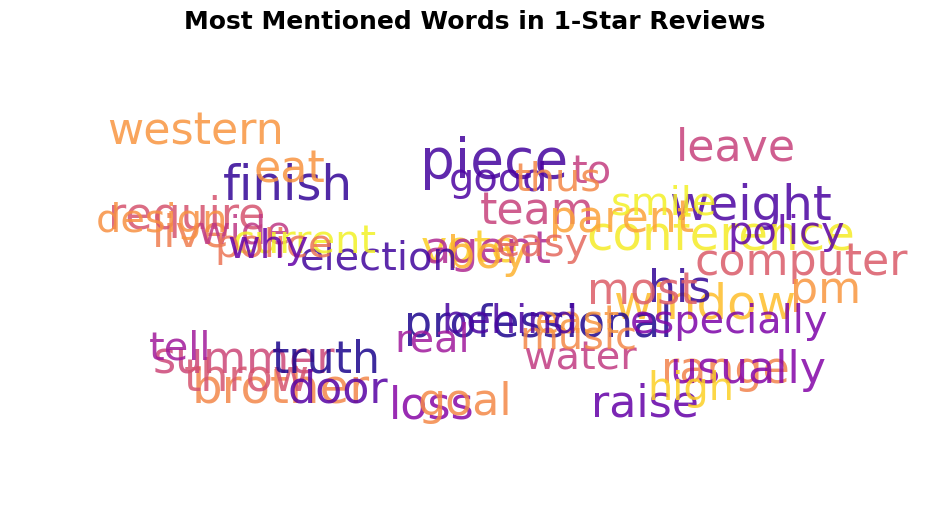

💡 Insight: Highlights major complaints driving 1-star ratings.


In [40]:
# 💬 9. What are the most mentioned words in 1-star reviews?
# Collect 1-star review words
low_reviews = " ".join(df.loc[df["rating_num"]==1, "cleaned_review_basic"])
freq = Counter(low_reviews.split()).most_common(50)  # top 50 words
top_words, counts = zip(*freq)

# Normalize sizes
sizes = np.array(counts)
sizes = 1000 * (sizes / sizes.max())

# Random positions
x = np.random.rand(len(top_words)) * 0.8 + 0.1
y = np.random.rand(len(top_words)) * 0.6 + 0.2

# Random colors
colors = [plt.cm.plasma(random.random()) for _ in range(len(top_words))]

# Plot
plt.figure(figsize=(12,6))
for i, word in enumerate(top_words):
    plt.text(x[i], y[i], word,
             fontsize=sizes[i]**0.5 + 8,
             color=colors[i],
             ha='center', va='center', alpha=0.85)

plt.axis('off')
plt.title("Most Mentioned Words in 1-Star Reviews", fontsize=18, fontweight="bold")
plt.show()

print("💡 Insight: Highlights major complaints driving 1-star ratings.")

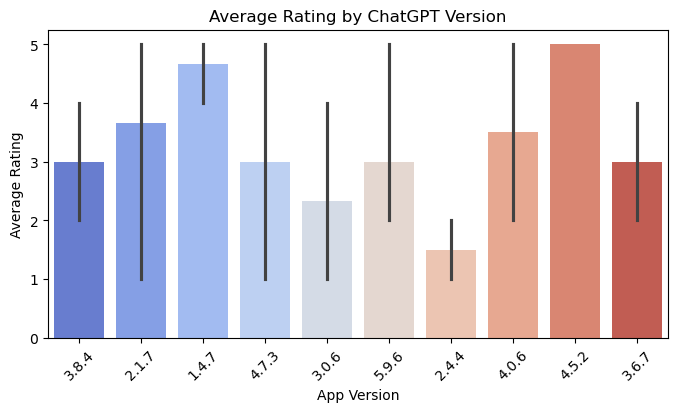

💡 Insight: Compare versions — which release achieved highest satisfaction.


In [41]:
# 📱🧪 10. What ChatGPT version received the highest average rating?
if "version" in df.columns:
    top_versions = df["version"].value_counts().head(10).index
    plt.figure(figsize=(8,4))
    sns.barplot(x="version", y="rating_num", data=df[df["version"].isin(top_versions)],
                estimator="mean", palette="coolwarm")
    plt.title("Average Rating by ChatGPT Version")
    plt.xlabel("App Version")
    plt.ylabel("Average Rating")
    plt.xticks(rotation=45)
    plt.show()
    print("💡 Insight: Compare versions — which release achieved highest satisfaction.")
else:
    print("⚠️ Version column not found.")

# Pre Processing and Feature Engineering

In [42]:
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

IN_CLEAN = "cleaned_reviews.csv"
OUT_PREPROC = "data/preprocessed_reviews.csv"
VECT_PATH = "models/tfidf_vectorizer.pkl"
LBL_PATH = "models/label_encoder.pkl"
X_NPZ = "models/X_tfidf.npz"

In [43]:
# Load
df = pd.read_csv(IN_CLEAN)
print("Loaded:", df.shape)

Loaded: (250, 9)


In [44]:
# Choose text column
if "cleaned_review_basic" not in df.columns:
    if "review_text" in df.columns:
        df["cleaned_review_basic"] = df["review_text"]
    else:
        raise ValueError("No text column found!")

# drop blanks
df = df.dropna(subset=["cleaned_review_basic"])
df = df[df["cleaned_review_basic"].str.strip() != ""]
print("After dropping blanks:", df.shape)

After dropping blanks: (250, 9)


In [45]:
# Basic Cleaning
def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned_review_final"] = df["cleaned_review_basic"].apply(clean_text_basic)
print("Sample cleaned text:", df["cleaned_review_final"].head(3).tolist())

Sample cleaned text: ['every quite sense including six lot have never effect fill general relationship save security land record class democrat hundred full nearly recent', 'ask develop bag also his worker pass expert white arm similar compare manager action sure us million crime six member recognize past', 'if customer address region try near risk next on girl spring paper create upon offer end imagine blood authority family water']


In [46]:
# Numeric features
df["review_length_words"] = df["cleaned_review_final"].apply(lambda x: len(x.split()))
df["helpful_votes_num"] = df.get("helpful_votes_num", 0)

In [47]:
# TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=20000, sublinear_tf=True)
X_tfidf = tfidf.fit_transform(df["cleaned_review_final"])
print("TF-IDF shape:", X_tfidf.shape)

# save artifacts
joblib.dump(tfidf, VECT_PATH)
sparse.save_npz(X_NPZ, X_tfidf)
df[["cleaned_review_final","sentiment","review_length_words","helpful_votes_num"]].to_csv(OUT_PREPROC, index=False)

TF-IDF shape: (250, 612)


In [48]:
# Label Encoding
le = LabelEncoder()
y = le.fit_transform(df["sentiment"])
joblib.dump(le, LBL_PATH)
print("Label classes:", le.classes_)

Label classes: ['negative' 'neutral' 'positive']


# Model training & evaluation

In [49]:
sns.set_theme(style="whitegrid")

In [50]:
# Load Preprocessed Data
tfidf = joblib.load("models/tfidf_vectorizer.pkl")
le = joblib.load("models/label_encoder.pkl")
X = sparse.load_npz("models/X_tfidf.npz")
df = pd.read_csv("data/preprocessed_reviews.csv")
y = le.transform(df["sentiment"])

print("✅ Data loaded successfully")
print("X shape:", X.shape)
print("Label classes:", le.classes_)

✅ Data loaded successfully
X shape: (250, 612)
Label classes: ['negative' 'neutral' 'positive']


In [51]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, " | Test shape:", X_test.shape)

Train shape: (200, 612)  | Test shape: (50, 612)


In [52]:
# Train logistic regression
print("\n🚀 Training Logistic Regression model...")
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)
print("✅ Training complete!")


🚀 Training Logistic Regression model...
✅ Training complete!


In [53]:
# Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print(f"\n📊 Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {f1:.4f}\n")
print("Detailed classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


📊 Model Performance:
Accuracy: 0.3800
Macro F1 Score: 0.3510

Detailed classification report:
              precision    recall  f1-score   support

    negative       0.42      0.42      0.42        19
     neutral       0.20      0.17      0.18        12
    positive       0.43      0.47      0.45        19

    accuracy                           0.38        50
   macro avg       0.35      0.35      0.35        50
weighted avg       0.37      0.38      0.37        50



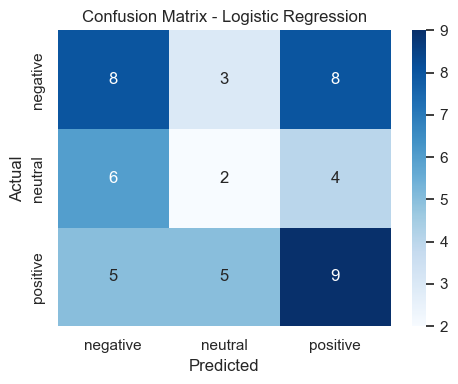

In [54]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

In [55]:
# Save model
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/logisticregression.pkl")
print("\n💾 Saved model as models/logisticregression.pkl")


💾 Saved model as models/logisticregression.pkl


In [56]:
pip install streamlit-lottie

  Using cached streamlit_lottie-0.0.5-py3-none-any.whl.metadata (3.3 kB)
Using cached streamlit_lottie-0.0.5-py3-none-any.whl (802 kB)
Note: you may need to restart the kernel to use updated packages.
